# Домашнее задание к модулю по Computer Vision

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

In [3]:
class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

In [4]:
class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3


    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

In [5]:
def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):


    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=bool)
    mask = np.zeros((nx, ny), dtype=bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1

    if rectangles:
        mask = np.zeros((nx, ny), dtype=bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            m = np.zeros((nx, ny), dtype=bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h

        label[mask, 2] = 1

        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    if rectangles:
        return image, label
    else:
        return image, label[..., 1]

In [6]:
def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb

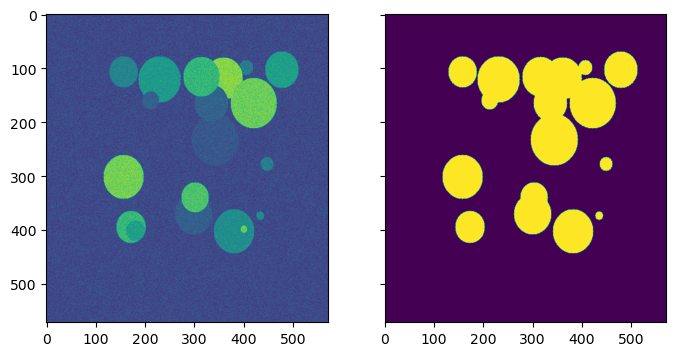

In [7]:
nx = 572
ny = 572
generator = GrayScaleDataProvider(nx, ny, cnt=20)
x_test, y_test = generator(1)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax[0].imshow(x_test[0, ..., 0], aspect="auto")
ax[1].imshow(y_test[0, ..., 1], aspect="auto")

plt.show()

## Task 1:

У вас есть ноутбук circle_generator.ipynb Ваша задача сгенерировать изображения кружочков и натренировать нейронную сеть с архитектурой UNet на предмет сегментации кружочков на сгенерированных изображениях.
- Не забываем про разбиение на train/test/validation
- Считать значение лосса и метрики на трейне и тесте во время обучения
- Построить график лосса на трейне и тесте после обучения
- Оценить качество модели на валидации на выбранной метрике.

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.metrics import jaccard_score
import random
import cv2

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Генерация кружочков:</h4>
</div>

In [9]:
class CircleSegmentationDataset(Dataset):
    """
    PyTorch Dataset that wraps GrayScaleDataProvider to supply synthetic circle images and masks.
    """
    def __init__(self, provider, count):
        self.provider = provider
        self.count = count

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        x, y = self.provider(1)
        x = x[0].transpose(2, 0, 1)  # to (C, H, W)
        y = y[0].transpose(2, 0, 1)  # to (n_class, H, W)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y[1], dtype=torch.float32)

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> U-Net:</h4>
</div>

U-Net:

In [10]:
class UNet(nn.Module):
    """
    A simplified implementation of the UNet architecture for binary image segmentation.
    """
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
            )
        self.enc1 = CBR(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = CBR(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = CBR(128, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.final(d1))

Data Preparation

In [11]:
nx = 572
ny = 572
provider = GrayScaleDataProvider(nx, ny, cnt=20)
#provider = GrayScaleDataProvider(nx=128, ny=128, cnt=5)
dataset = CircleSegmentationDataset(provider, count=100)

In [12]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [13]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

Model Training:

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
train_losses, val_losses = [], []
epochs = 10
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_losses.append(total_train_loss / len(train_loader))

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y.unsqueeze(1))
            total_val_loss += loss.item()
    val_losses.append(total_val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/10 - Train Loss: 0.4995, Val Loss: 0.2813
Epoch 2/10 - Train Loss: 0.2015, Val Loss: 0.1293
Epoch 3/10 - Train Loss: 0.1242, Val Loss: 0.0854
Epoch 4/10 - Train Loss: 0.0822, Val Loss: 0.0607
Epoch 5/10 - Train Loss: 0.0725, Val Loss: 0.0704
Epoch 6/10 - Train Loss: 0.0694, Val Loss: 0.3287
Epoch 7/10 - Train Loss: 0.0722, Val Loss: 0.0708
Epoch 8/10 - Train Loss: 0.0622, Val Loss: 0.0723
Epoch 9/10 - Train Loss: 0.0643, Val Loss: 0.0537
Epoch 10/10 - Train Loss: 0.1046, Val Loss: 0.0705


Loss Plot

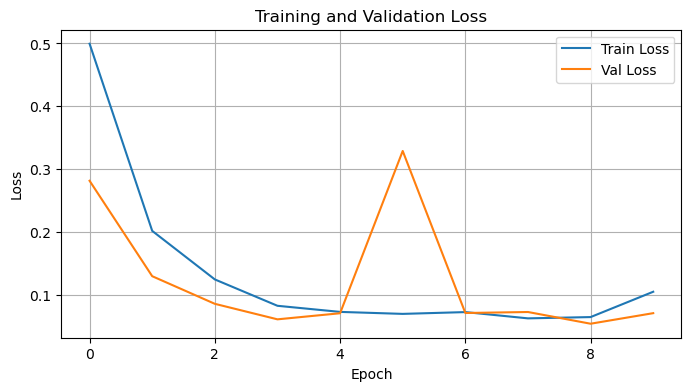

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

IoU Evaluation on Validation

In [17]:
model.eval()
ious = []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = (out > 0.5).float()
        for p, t in zip(pred, y.unsqueeze(1)):
            iou = jaccard_score(t.cpu().numpy().flatten(), p.cpu().numpy().flatten())
            ious.append(iou)

print(f"Mean IoU on validation set: {np.mean(ious):.4f}")


Mean IoU on validation set: 0.8142


IoU > 0.8 означает, что модель хорошо научилась отделять кружочки от фона.

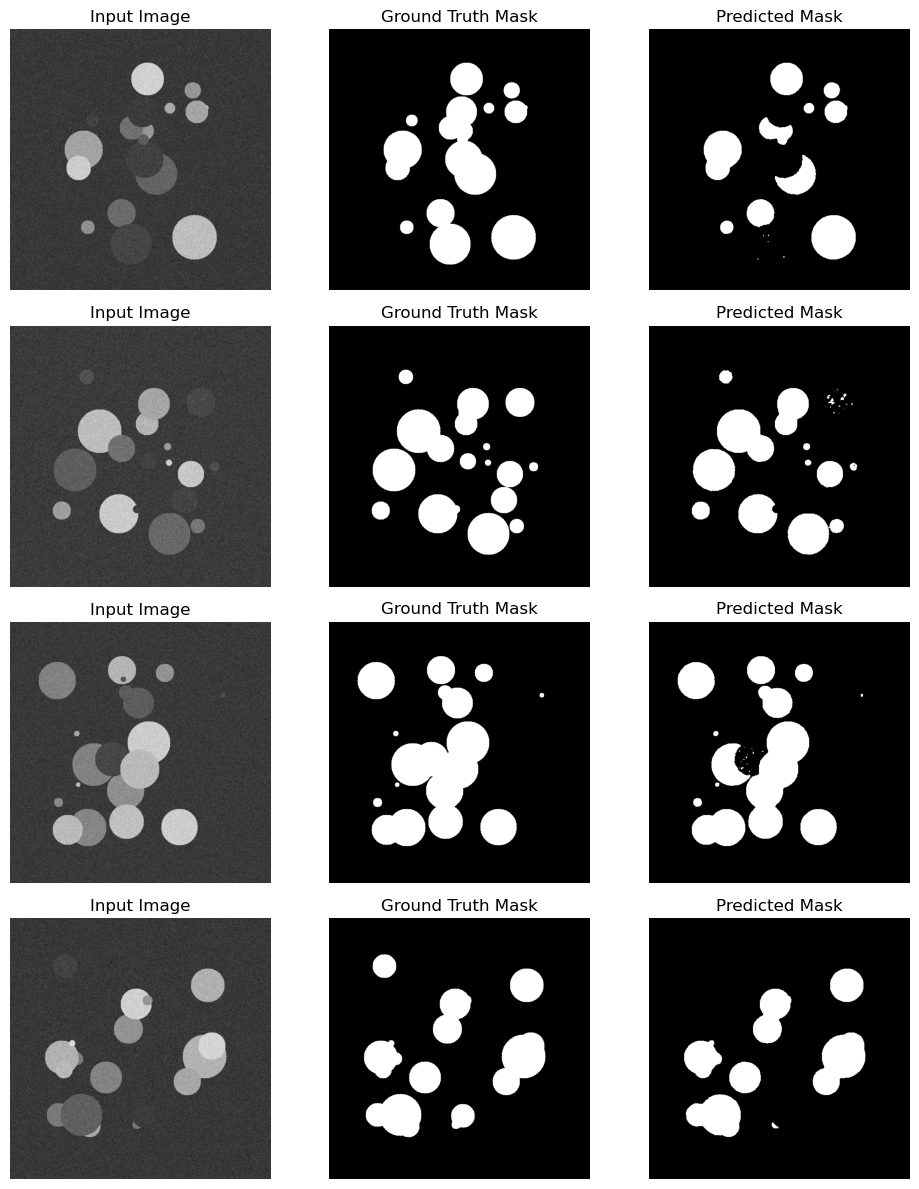

In [18]:
example_batch = next(iter(val_loader))
images, true_masks = example_batch
images, true_masks = images.to(device), true_masks.to(device)

with torch.no_grad():
    predicted_masks = model(images)
    predicted_masks = (predicted_masks > 0.5).float()

# Визуализация нескольких примеров
num_samples = min(4, images.shape[0])
fig, axs = plt.subplots(num_samples, 3, figsize=(10, 3 * num_samples))

for i in range(num_samples):
    axs[i, 0].imshow(images[i][0].cpu(), cmap='gray')
    axs[i, 0].set_title("Input Image")
    axs[i, 1].imshow(true_masks[i].cpu(), cmap='gray')
    axs[i, 1].set_title("Ground Truth Mask")
    axs[i, 2].imshow(predicted_masks[i][0].cpu(), cmap='gray')
    axs[i, 2].set_title("Predicted Mask")
    for j in range(3):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()